In [30]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns

import pfjax as pf
from pfjax.models import LotVolModel
import projplot as pjp

# module containing pfjax (for now)
sns.set_style("darkgrid")
key = random.PRNGKey(0)

# parameter values

alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.0001
sigma_l = 0.0001
tau_h = 0.1
tau_l = 0.1

theta = jnp.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 2
n_obs = 100
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)


x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)


In [31]:
n_res = 4
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)
x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas_4, x_state_4 = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

In [32]:
n_res = 8
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)
x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas_8, x_state_8 = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

In [33]:
n_res = 16
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)
x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas_16, x_state_16 = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

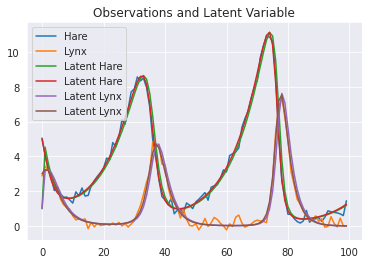

In [34]:
import matplotlib.pyplot as plt
plt.plot(y_meas[:, 0], label = "Hare")
plt.plot(y_meas[:, 1], label = "Lynx")
plt.plot(jnp.exp(x_state[:, :, 0]), label="Latent Hare")
plt.plot(jnp.exp(x_state[:, :, 1]), label="Latent Lynx")
plt.title("Observations and Latent Variable")
plt.legend()

In [35]:
x_state.shape

(100, 2, 2)

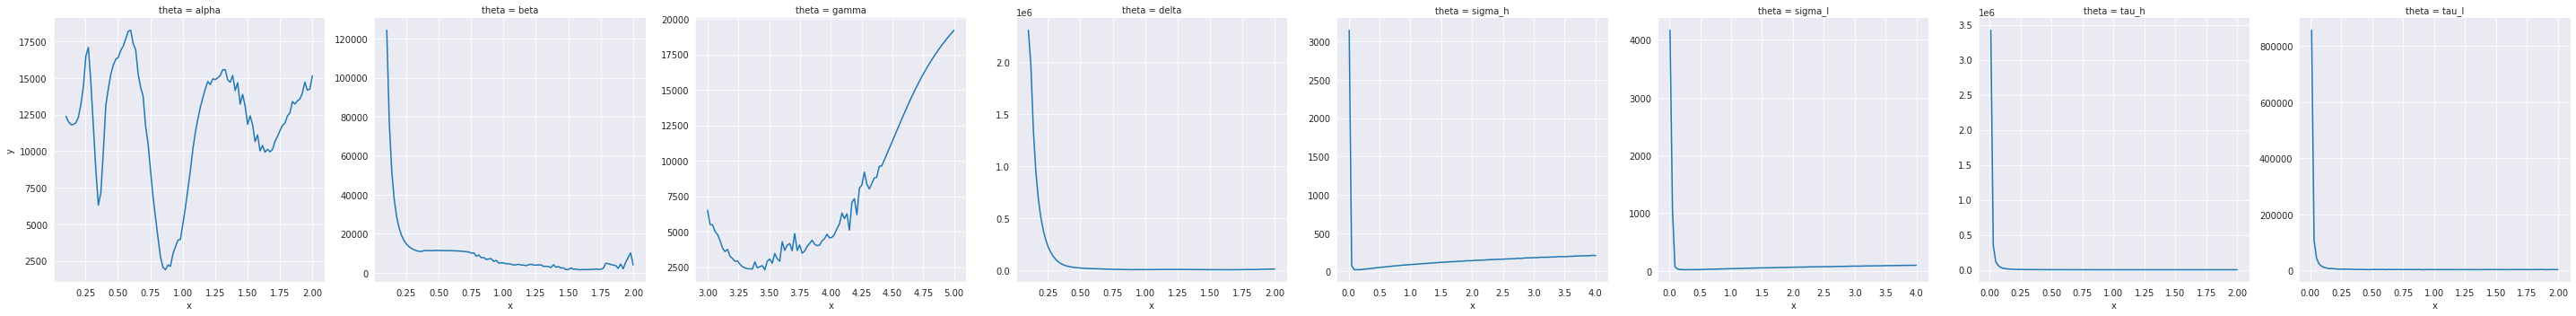

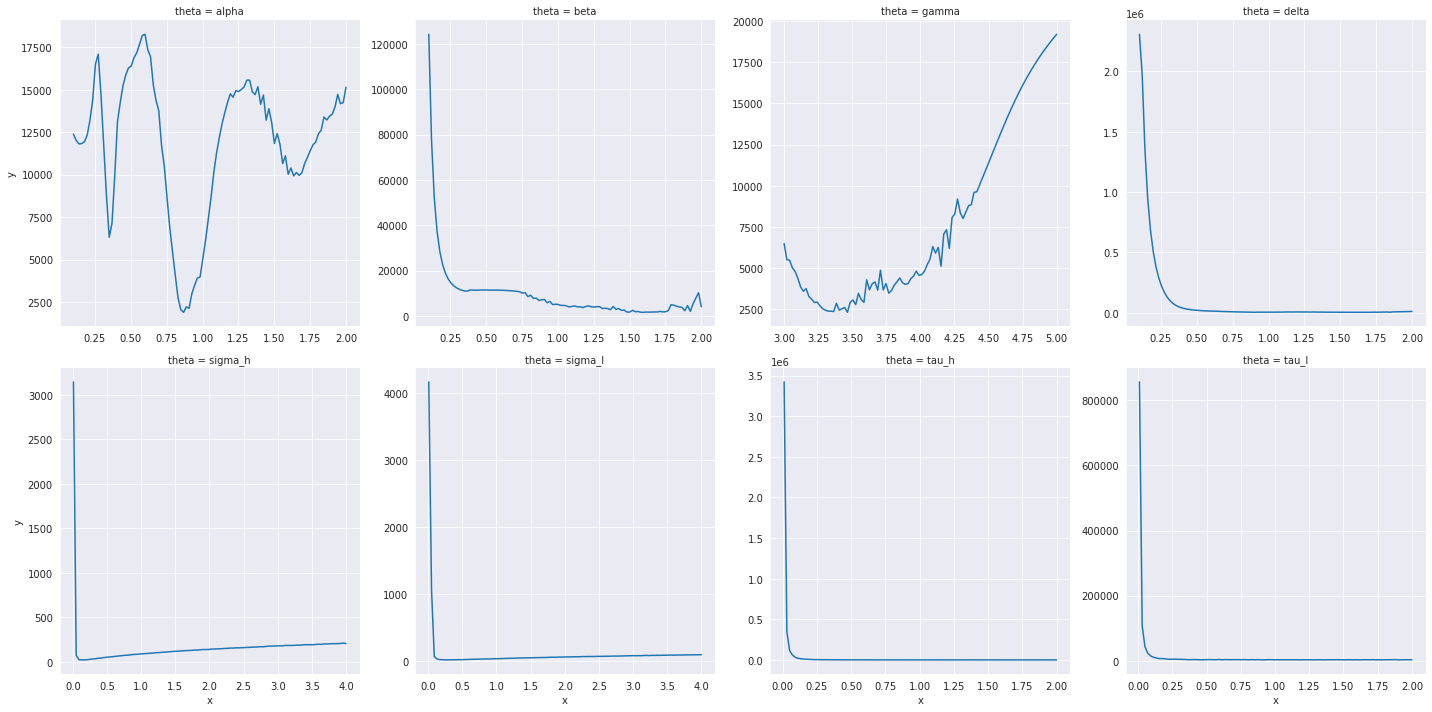

In [36]:
import pfjax.experimental.particle_filter as pfex
def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for projxvals and projdata.
    """
    xvals = pjp.projxvals(x, x_lims, n_pts)
    return pjp.projdata(fun, xvals, x_names, is_vectorized=False)


theta_lims = np.array([[0.1, 2.0], [0.1, 2.0], [3.0, 5.0], [0.1, 2.0], [0.01, 4.], [0.01, 4.], [0.01, 2.], [0.01, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000


@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    temp = pf.particle_loglik(temp["logw"])
    return -temp


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

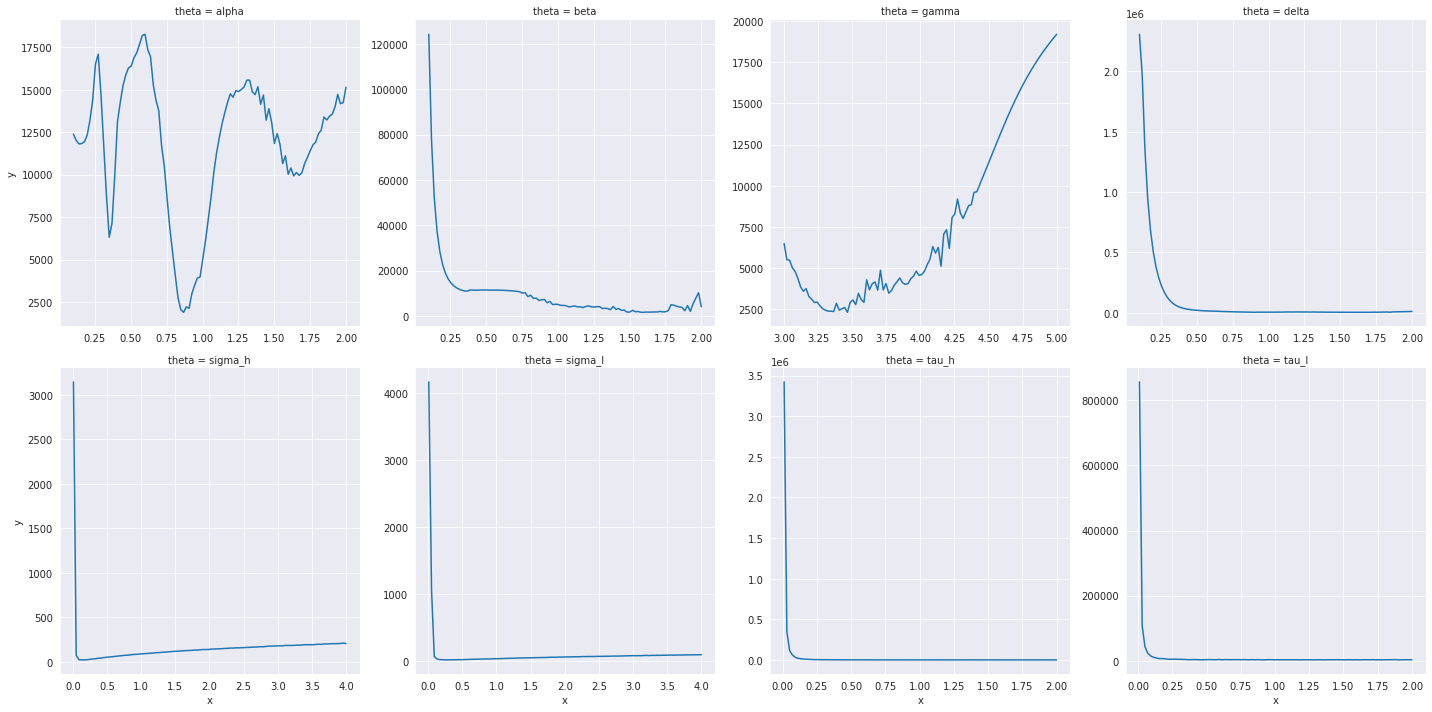

In [37]:
sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [38]:
import optax
from functools import partial
def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    '''
    Args:
        params: A jnp.array that represents the values of the parameters before the gradient update.
        subkey: The subkey for the current loop iteration.
        opt_state: The optimizer state of the parameters.
        grad_fun: The function with which to take the gradients with respect to.
        n_particles: The number of particles for the particle filter.
        y_meas: The observed data `y_meas`
        model: The model class which has the predefined methods to run the forward pass.
        learning_rate: The learning rate for the stochastic optimization method.
        mask: A mask (0 or 1 vector) which represents the parameters that we wish to update in an iteration.
        optimizer: The choice of stochastic optimizer (e.g. Adam/Adagrad)
    
    Returns:
        params: The updated parameters at the end of the stochastic optimization step.
    '''
    # First we obtain the gradients of the gradient function with respect to the `grad_fun`.
    params_update = jax.grad(grad_fun, argnums=0)(
        params, subkey, n_particles, y_meas, model)
    # Updating the params with respect to the mask.
    params_update = jnp.where(mask, params_update, 0)
    # Applying the updates to the parameters except for those that are masked.
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates) 


def stoch_opt(model, params, grad_fun, y_meas, n_particles=100, iterations=10,
              learning_rate=0.01, key=1, mask=None):
    """
    Args:
        model: The model class for which all of the functions are defined.
        params: A jnp.array that represents the initial values of the parameters.
        grad_fun: The function which we would like to take the gradient with respect to.
        y_meas: The measurements of the observations required for the particle filter.
        n_particles: The number of particles to use in the particle filter.
        iterations: The number of iterations to run the gradient descent for.
        learning_rate: The learning rate for the gradient descent algorithm.
        key: The key required for the prng.
        mask: The mask over which dimensions we would like to perform the optimization.
    
    Returns:
        params: The final value of the parameters.
    """
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    # Partially evaluate the function with respect to all of the parameters that do not change over time.
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, grad_fun=grad_fun, 
                                    optimizer=optimizer)
    # JIT the update step.
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    # Every iteration, the keys must be split to obtain several subkeys for which we have to take the update step.
    keys = random.split(key, iterations)
    for subkey in keys:
        params = update_fn(params, subkey, opt_state)
    return params 
    

def particle_neg_loglik(theta, key, n_particles, y_meas, model):
    """
    Evaluate the bootstrap particle filter estimate of the negative log-likelihood at parameter values \theta. Runs the particle filter for each timestep in y_meas and sums the log-weights for each particle
    Args:
        theta: A `jnp.array` that represents the values of the parameters on the log scale.
        key: The key required for the prng.
        n_particles: The number of particles to use in the particle filter.
        y_meas: The measurements of the observations required for the particle filter.
    Returns:
        Estimate of the negative log-likelihood evaluated at \theta. 
    """
    theta_reg = jnp.array([theta[0], theta[1], theta[2], theta[3], jnp.exp(theta[4]), jnp.exp(theta[5]), 
                           jnp.exp(theta[6]), jnp.exp(theta[7])])
    ret = pf.particle_filter(model, key, y_meas, theta_reg, n_particles)
    sum_particle_lweights = pf.particle_loglik(ret['logw'])
    return -sum_particle_lweights


def hessian_averaging_alg(optima, key, grad_fun, y_meas, model, iterations=100, n_particles=500):
    '''
    Computes the average hessian at a particular optima across several iterations.
    Args: 
        optima: A `jnp.array` representing the optima converged in the `stoch_opt` function.
        key: The key required for the prng.
        grad_fun: The function which we would like to take the gradient with respect to.
        y_meas: The measurements of the observations required for the particle filter.
        model: The model class for which all of the functions are defined.
        iterations: The number of iterations to run the gradient descent for.
        n_particles: The number of particles to use in the particle filter.
    Returns:
        Returns one hessian for each iteration in the form of a `jnp.array`.
    '''
    hessian_fn = jax.jit(jax.jacfwd(jax.jacrev(partial(grad_fun, n_particles=n_particles, model=model))))
    keys = random.split(key, iterations)
    hess = jax.vmap(lambda i: hessian_fn(optima, keys[i], y_meas=y_meas))(jnp.arange(iterations))
    return hess

In [39]:
params_unc = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., jnp.log(0.0001), jnp.log(0.0001), jnp.log(0.25), jnp.log(0.25)]), particle_neg_loglik, y_meas, key=key, learning_rate=0.001, iterations=1000, n_particles=500,
         mask=np.array([1,1,1,1,1,1,1,1]))
params_orig = jnp.array(jnp.array([params_unc[0], params_unc[1], params_unc[2], params_unc[3], jnp.exp(params_unc[4]), jnp.exp(params_unc[5]), 
                           jnp.exp(params_unc[6]), jnp.exp(params_unc[7])]))
params_orig


/root/workspace/pfjax/new_env/lib/python3.8/site-packages/jax/interpreters/mlir.py:512: UserWarning: Some donated buffers were not usable: ShapedArray(float32[8]).
Donation is not implemented for cpu.
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn(f"Some donated buffers were not usable: {', '.join(unused_donations)}.\n{msg}")


DeviceArray([9.1200113e-01, 1.3200150e+00, 3.9200058e+00, 9.7200036e-01,
             1.6391856e-04, 1.0408285e-04, 6.7957735e-01, 5.6423646e-01],            dtype=float32)

In [40]:
params_unc_4 = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., jnp.log(0.0001), jnp.log(0.0001), jnp.log(0.25), jnp.log(0.25)]), particle_neg_loglik, y_meas_4, key=key, learning_rate=0.001, iterations=1000, n_particles=500,
         mask=np.array([1,1,1,1,1,1,1,1]))
params_orig_4 = jnp.array(jnp.array([params_unc[0], params_unc[1], params_unc[2], params_unc[3], jnp.exp(params_unc[4]), jnp.exp(params_unc[5]), 
                           jnp.exp(params_unc[6]), jnp.exp(params_unc[7])]))
params_orig_4

DeviceArray([9.1200113e-01, 1.3200150e+00, 3.9200058e+00, 9.7200036e-01,
             1.6391856e-04, 1.0408285e-04, 6.7957735e-01, 5.6423646e-01],            dtype=float32)

In [41]:
params_unc_8 = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., jnp.log(0.0001), jnp.log(0.0001), jnp.log(0.25), jnp.log(0.25)]), particle_neg_loglik, y_meas_8, key=key, learning_rate=0.001, iterations=1000, n_particles=500,
         mask=np.array([1,1,1,1,1,1,1,1]))
params_orig_8 = jnp.array(jnp.array([params_unc[0], params_unc[1], params_unc[2], params_unc[3], jnp.exp(params_unc[4]), jnp.exp(params_unc[5]), 
                           jnp.exp(params_unc[6]), jnp.exp(params_unc[7])]))
params_orig_8

DeviceArray([9.1200113e-01, 1.3200150e+00, 3.9200058e+00, 9.7200036e-01,
             1.6391856e-04, 1.0408285e-04, 6.7957735e-01, 5.6423646e-01],            dtype=float32)

In [42]:
params_unc_16 = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., jnp.log(0.0001), jnp.log(0.0001), jnp.log(0.25), jnp.log(0.25)]), particle_neg_loglik, y_meas_16, key=key, learning_rate=0.001, iterations=1000, n_particles=500,
         mask=np.array([1,1,1,1,1,1,1,1]))
params_orig_16 = jnp.array(jnp.array([params_unc[0], params_unc[1], params_unc[2], params_unc[3], jnp.exp(params_unc[4]), jnp.exp(params_unc[5]), 
                           jnp.exp(params_unc[6]), jnp.exp(params_unc[7])]))
params_orig_16

DeviceArray([9.1200113e-01, 1.3200150e+00, 3.9200058e+00, 9.7200036e-01,
             1.6391856e-04, 1.0408285e-04, 6.7957735e-01, 5.6423646e-01],            dtype=float32)

In [43]:
hessian_fn = jax.jacfwd(jax.jacrev(particle_neg_loglik))
additive_const = 1e-2
hess = hessian_fn(params_orig, key, n_particles=1000, y_meas=y_meas, model=lotvol_model)
var_hat = jnp.linalg.inv(hess)
temp = jnp.all(jnp.linalg.eigvals(var_hat) >= 0)
print("Original Hessian estimate is positive semidefinite: ", temp)
var_hat = np.array(var_hat)
var_hat[np.diag_indices_from(var_hat)] += additive_const
temp = jnp.all(jnp.linalg.eigvals(jnp.array(var_hat)) >= 0)
print("New Hessian Estimate obtained by adding {0} to original is psd: ".format(additive_const), temp)


Original Hessian estimate is positive semidefinite:  True
New Hessian Estimate obtained by adding 0.01 to original is psd:  True


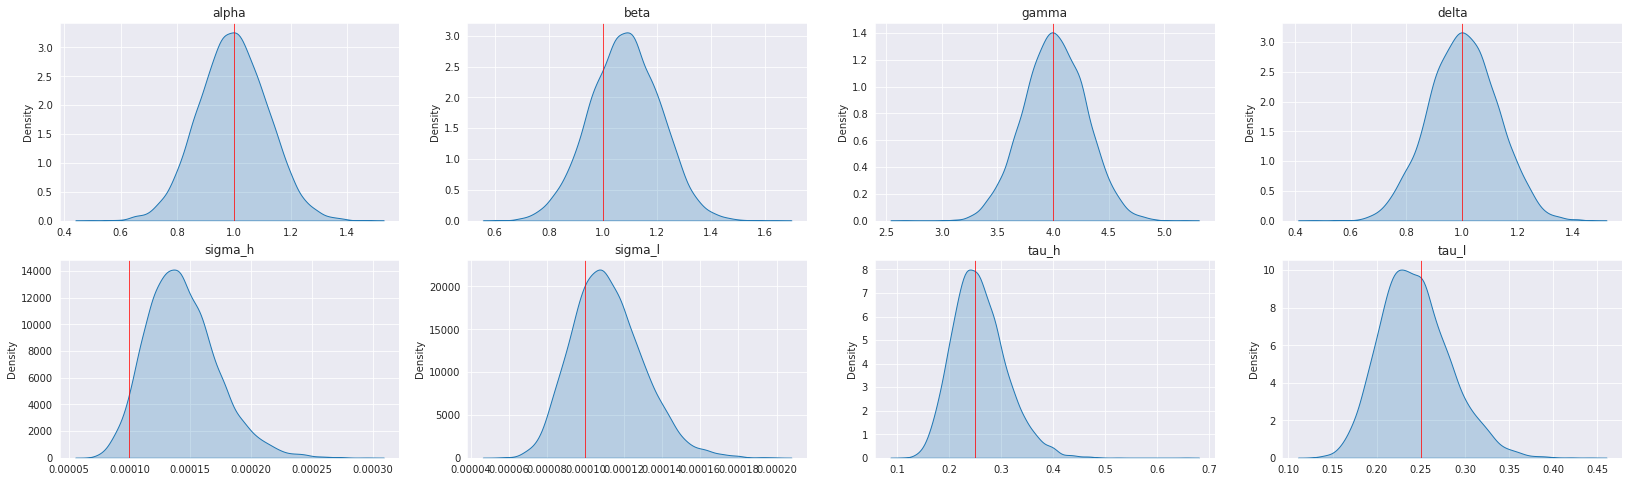

In [51]:
mle_samples = np.array(random.multivariate_normal(key=key, mean=params_unc, cov=var_hat, shape=(10_000, )))
mle_samples[:, 4] = np.exp(mle_samples[:, 4])
mle_samples[:, 5] = np.exp(mle_samples[:, 5])
mle_samples[:, 6] = np.exp(mle_samples[:, 6])
mle_samples[:, 7] = np.exp(mle_samples[:, 7])
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(28, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show()

In [113]:
data = pd.read_csv("lv_high.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

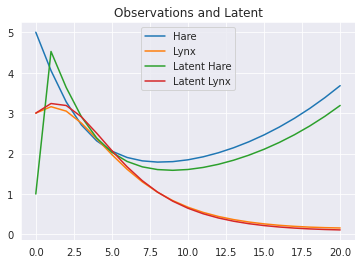

In [114]:
plt.plot(y_meas[:, 0], label="Hare")
plt.plot(y_meas[:, 1], label="Lynx")
plt.plot(jnp.exp(x_state[:21, 0, 0]), label="Latent Hare")
plt.plot(jnp.exp(x_state[:21, 1, 1]), label="Latent Lynx")
plt.title("Observations and Latent")
plt.legend()

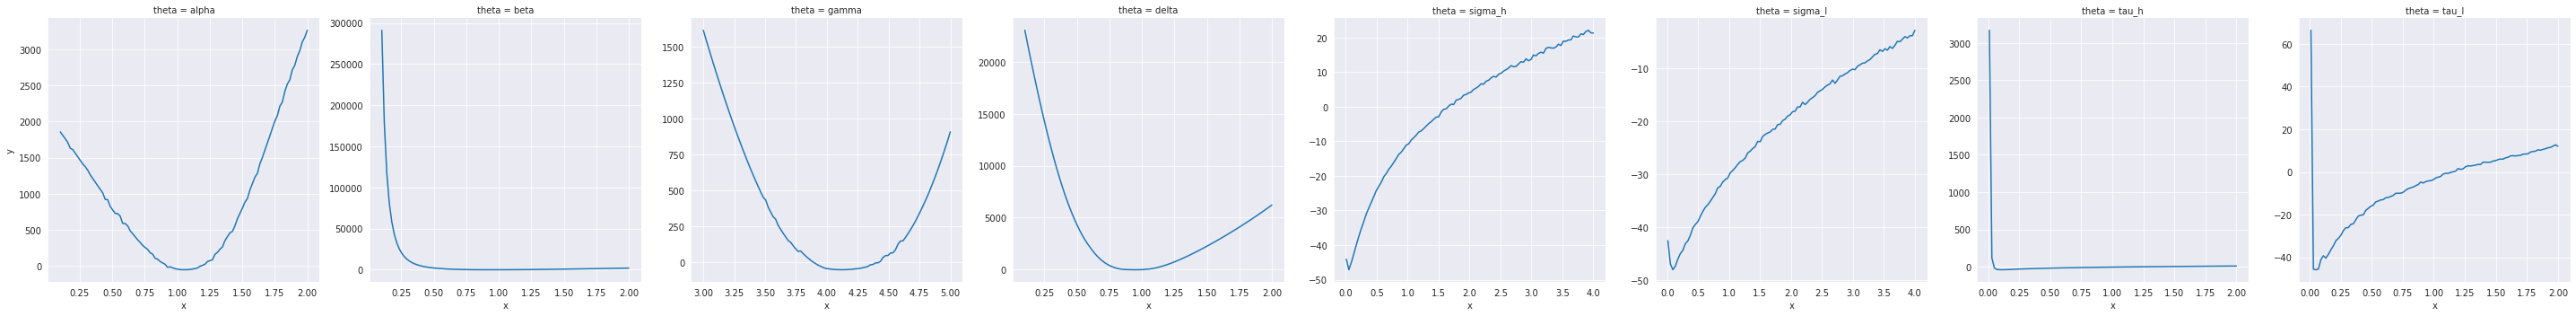

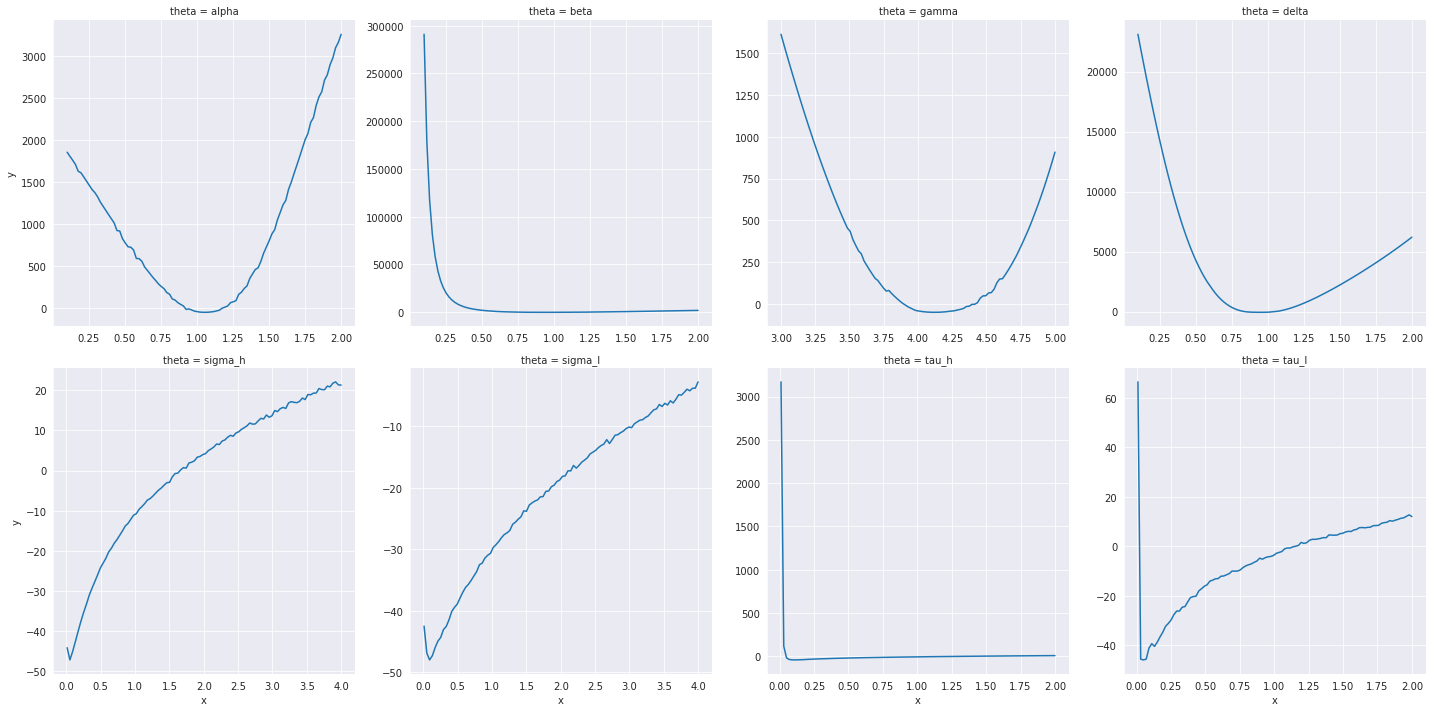

In [115]:
@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return -pf.particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

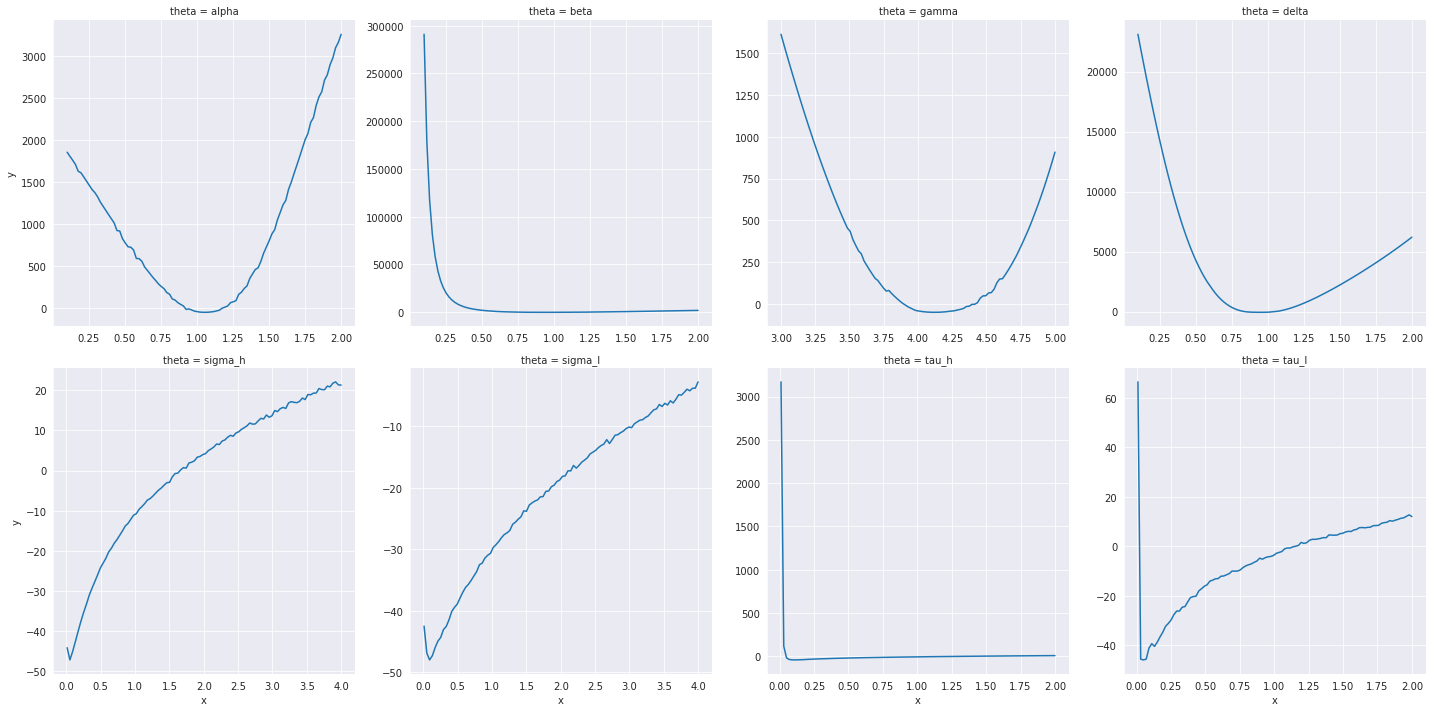

In [116]:
sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [120]:
params_unc = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., jnp.log(0.0001), jnp.log(0.0001), jnp.log(0.25), jnp.log(0.25)]), particle_neg_loglik, y_meas, key=key, learning_rate=0.001, iterations=1000, n_particles=500,
         mask=np.array([1,1,1,1,1,1,1,1]))
params_orig = jnp.array(jnp.array([params_unc[0], params_unc[1], params_unc[2], params_unc[3], jnp.exp(params_unc[4]), jnp.exp(params_unc[5]), 
                           jnp.exp(params_unc[6]), jnp.exp(params_unc[7])]))
params_orig

/root/workspace/pfjax/venv/lib/python3.8/site-packages/jax/interpreters/mlir.py:397: UserWarning: Some donated buffers were not usable: ShapedArray(float32[8]).
Donation is not implemented for cpu.
See an explanation at https://jax.readthedocs.io/en/latest/notebooks/faq.html#buffer-donation.
  warnings.warn(f"Some donated buffers were not usable: {', '.join(unused_donations)}.\n{msg}")


DeviceArray([9.9200010e-01, 9.6600044e-01, 3.9080067e+00, 9.1800106e-01,
             9.2863935e-05, 1.0019998e-04, 9.1969796e-02, 9.1969796e-02],            dtype=float32)

In [54]:
hessian_fn = jax.jacfwd(jax.jacrev(particle_neg_loglik))
additive_const = 1e-2
hess = hessian_fn(params_orig, key, n_particles=1000, y_meas=y_meas, model=lotvol_model)
var_hat = jnp.linalg.inv(hess)
temp = jnp.all(jnp.linalg.eigvals(var_hat) >= 0)
print("Original Hessian estimate is positive semidefinite: ", temp)
var_hat = np.array(var_hat)
var_hat[np.diag_indices_from(var_hat)] += additive_const
temp = jnp.all(jnp.linalg.eigvals(jnp.array(var_hat)) >= 0)
print("New Hessian Estimate obtained by adding {0} to original is psd: ".format(additive_const), temp)


Original Hessian estimate is positive semidefinite:  True
New Hessian Estimate obtained by adding 0.01 to original is psd:  True


In [55]:
additive_const = 1e-2
hess_4 = hessian_fn(params_orig_4, key, n_particles=1000, y_meas=y_meas_4, model=lotvol_model)
var_hat_4 = jnp.linalg.inv(hess_4)
temp = jnp.all(jnp.linalg.eigvals(var_hat_4) >= 0)
print("Original Hessian estimate is positive semidefinite: ", temp)
var_hat_4 = np.array(var_hat_4)
var_hat_4[np.diag_indices_from(var_hat_4)] += additive_const
temp = jnp.all(jnp.linalg.eigvals(jnp.array(var_hat_4)) >= 0)
print("New Hessian Estimate obtained by adding {0} to original is psd: ".format(additive_const), temp)

Original Hessian estimate is positive semidefinite:  True
New Hessian Estimate obtained by adding 0.01 to original is psd:  True


In [56]:
additive_const = 1e-2
hess_8 = hessian_fn(params_orig_8, key, n_particles=1000, y_meas=y_meas_8, model=lotvol_model)
var_hat_8 = jnp.linalg.inv(hess_8)
temp = jnp.all(jnp.linalg.eigvals(var_hat_8) >= 0)
print("Original Hessian estimate is positive semidefinite: ", temp)
var_hat_8 = np.array(var_hat_8)
var_hat_8[np.diag_indices_from(var_hat_8)] += additive_const
temp = jnp.all(jnp.linalg.eigvals(jnp.array(var_hat_8)) >= 0)
print("New Hessian Estimate obtained by adding {0} to original is psd: ".format(additive_const), temp)

Original Hessian estimate is positive semidefinite:  True
New Hessian Estimate obtained by adding 0.01 to original is psd:  True


In [57]:
additive_const = 1e-2
hess_16 = hessian_fn(params_orig_16, key, n_particles=1000, y_meas=y_meas_16, model=lotvol_model)
var_hat_16 = jnp.linalg.inv(hess_16)
temp = jnp.all(jnp.linalg.eigvals(var_hat_16) >= 0)
print("Original Hessian estimate is positive semidefinite: ", temp)
var_hat_16 = np.array(var_hat_16)
var_hat_16[np.diag_indices_from(var_hat_16)] += additive_const
temp = jnp.all(jnp.linalg.eigvals(jnp.array(var_hat_16)) >= 0)
print("New Hessian Estimate obtained by adding {0} to original is psd: ".format(additive_const), temp)

Original Hessian estimate is positive semidefinite:  True
New Hessian Estimate obtained by adding 0.01 to original is psd:  True


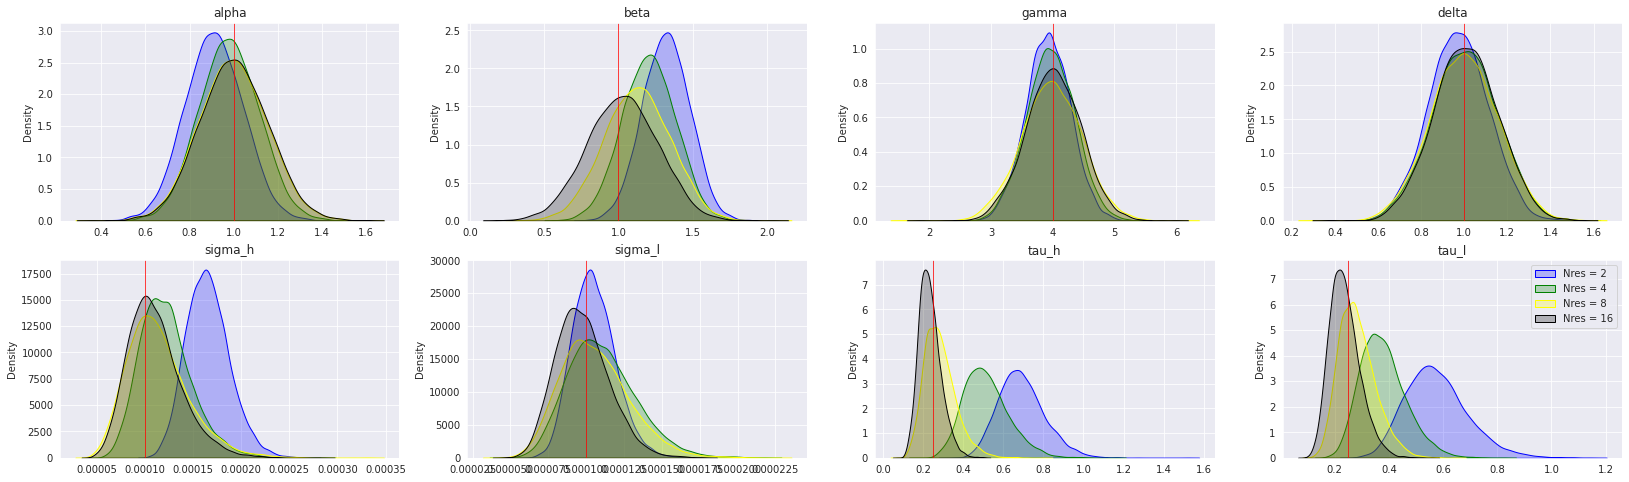

In [61]:
mle_samples = np.array(random.multivariate_normal(key=key, mean=params_unc, cov=var_hat, shape=(10_000, )))
mle_samples_4 = np.array(random.multivariate_normal(key=key, mean=params_unc_4, cov=var_hat_4, shape=(10_000, )))
mle_samples_8 = np.array(random.multivariate_normal(key=key, mean=params_unc_8, cov=var_hat_8, shape=(10_000, )))
mle_samples_16 = np.array(random.multivariate_normal(key=key, mean=params_unc_16, cov=var_hat_16, shape=(10_000, )))
mle_samples[:, 4] = np.exp(mle_samples[:, 4])
mle_samples_4[:, 4] = np.exp(mle_samples_4[:, 4])
mle_samples_8[:, 4] = np.exp(mle_samples_8[:, 4])
mle_samples_16[:, 4] = np.exp(mle_samples_16[:, 4])
mle_samples[:, 5] = np.exp(mle_samples[:, 5])
mle_samples_4[:, 5] = np.exp(mle_samples_4[:, 5])
mle_samples_8[:, 5] = np.exp(mle_samples_8[:, 5])
mle_samples_16[:, 5] = np.exp(mle_samples_16[:, 5])
mle_samples[:, 6] = np.exp(mle_samples[:, 6])
mle_samples_4[:, 6] = np.exp(mle_samples_4[:, 6])
mle_samples_8[:, 6] = np.exp(mle_samples_8[:, 6])
mle_samples_16[:, 6] = np.exp(mle_samples_16[:, 6])
mle_samples[:, 7] = np.exp(mle_samples[:, 7])
mle_samples_4[:, 7] = np.exp(mle_samples_4[:, 7])
mle_samples_8[:, 7] = np.exp(mle_samples_8[:, 7])
mle_samples_16[:, 7] = np.exp(mle_samples_16[:, 7])
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(28, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True, color="Blue", label="Nres = 2").set_title(theta_names[ind])
    sns.kdeplot(mle_samples_4[:, ind], ax = _ax, shade = True, color="green", label="Nres = 4")
    sns.kdeplot(mle_samples_8[:, ind], ax = _ax, shade = True, color="yellow", label="Nres = 8")
    sns.kdeplot(mle_samples_16[:, ind], ax = _ax, shade = True, color="black", label="Nres = 16")
    plt.legend()
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show()
